# Decision Tree for N-dimensional data and labels
The code below implements a decision tree calculated on all the data, for one label depending on several independent variables.

## Libraries
First, some libraries are loaded and global figure settings are made for exporting.

In [253]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import log, e
import pylab
import random

# Figure settings
F = pylab.gcf()
plt.rc('text', usetex=True)
plt.rc('font', family='serif',size=12)

## Functions

### Functions for creating and plotting data

In [254]:
def createClusters(means, covs, npoints):
    """
    Generate `npoints` random points within two clusters characteristed by their `mean` and `diagonal covariance`
    # TODO generalize to return more than two clusters
    """
    x,y=[],[]
    for i in range(len(means)):
        x1,y1=np.random.multivariate_normal(means[i], covs[i], npoints).T
        x.append(np.array(x1))
        y.append(np.array(y1))
        
    return x,y

### Functions for entropy and splitting

In [255]:
def split(index, value, dataset):  # [2]
    """
    split a dataset (columns: variables, rows: data) in two according to some column (index) value 
    """
    left, right = list(), list()
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

    
def entropy(labels, base=None):  # [1]
    """
    Calculate the entropy for a set of labels
    """
    value, counts = np.unique(labels, return_counts=True)
    norm_counts = counts / counts.sum()
    base = e if base is None else base
    return -(norm_counts * np.log(norm_counts) / np.log(base)).sum()

def differentialEntropy():
    """
    # TODO implement: Gaussian entropy for continuous variables
    """
    pass
    

def entropy_discrete(dataset, col_index):
    """
    calculate the entropy values for all cuts on one attribute (left<cut, right>=cut).
    
    Parameters
    ----------
    dataset :
        Input array with data and label in rows. The last column contains the labels.
    col_index :
        The index of the column for which the entropy should be computed.
    """
    x_vals, entropy_vals = list(), list()
    uniquevals=(np.unique(dataset[:,col_index]))
    left_labels_unique, right_labels_unique = list(), list()
    
    for split_x in uniquevals[1:]:
        x_vals.append(split_x)

        # split
        left, right = split(col_index, split_x, dataset)
        left = np.asarray(left)
        right = np.asarray(right)

        # labels
        left_labels = left[:, -1]  # last column = labels
        right_labels = right[:, -1]
        
        #print(" ".join(left_labels))
        
        left_labels_unique.append(np.unique(left_labels))
        right_labels_unique.append(np.unique(right_labels))
        
        # entropy
        left_entropy = entropy(left_labels, base=2)
        right_entropy = entropy(right_labels, base=2)

        # total entropy for attribute
        entropy_attr_split = left_entropy * len(left) / len(dataset) + right_entropy * len(right) / len(dataset)
        entropy_vals.append(entropy_attr_split)

    return entropy_vals, x_vals, left_labels_unique, right_labels_unique

In [314]:
from matplotlib.pyplot import cm 

In [315]:
def plotData(clusters,title):
    """
    Plot the clustered data
    """
    fig, ax = plt.subplots()
    
    color=iter(cm.rainbow(np.linspace(0,1,len(clusters))))
    
    for i, c in enumerate(clusters):
        color_cluster=next(color)
        ax.plot(c[:,0], c[:,1], '.', color=color_cluster)

        x=c[:,0]
        y=c[:,1]
        n=[int(c) for c in c[:,2]]

        for i, txt in enumerate(n):
            ax.annotate(txt, (x[i],y[i]))
    
    
    
    ax.grid()
    plt.title(title)
 
    axes = plt.gca()
    
    axes.set_xlim([minRange-4*covariance,maxRange+4*covariance])
    axes.set_ylim([minRange-4*covariance,maxRange+4*covariance])
    
    #plt.savefig('/Users/cyrilwendl/Documents/EPFL/Projet SIE/SIE-Project/random_data.pdf', bbox_inches='tight')
    plt.show()

## Test Data
Next, some data is generated to test the functions above. 

First, some functions are used to generate a random mean of n clusters in d dimensions and their covariance.

In [322]:
def createMeans(clusters,dimensions,minRange=1,maxRange=100):
    """"""
    mean=[]
    for c in range(clusters):
        mean_c=[]
        for d in range(dimensions):
            mean_c.append(random.randint(minRange,maxRange))
        mean.append(mean_c)
    return mean

def createCovs(clusters, dimensions, covariance):
    """create covariance matrix for n clusters of dimension d with covariance c"""
    covs=[]
    for c in range(clusters):
        covs.append(np.identity(dimensions)*covariance)
    return covs

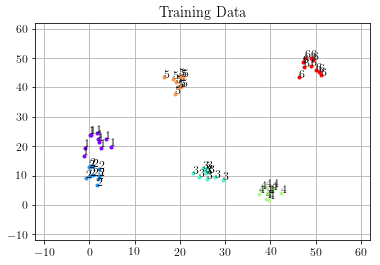

In [323]:
# cluster parameters
nclusters=6
dimensions=2
covariance=3
minRange=0
maxRange=50
npoints=10

def createData(clusters, dimensions, covariance, npoints):
    means=createMeans(clusters, dimensions, minRange, maxRange)
    covs=createCovs(clusters, dimensions, covariance)
    
    x,y=createClusters(means, covs, npoints)

    # zip for having tuples (x,y), round and unique for having discrete coordinates (eliminating duplicate points)
    clusters=[]
    for i in range(len(x)):
        clusters.append(np.unique(list(zip(x[i],y[i],np.ones(len(x[i]))*(i+1))),axis=0)) # np.ones: label 1 for first cluster
    dataset=np.asarray(np.concatenate(clusters,axis=0))
    return dataset, clusters
    # connect unique points of cluster 1 and cluster 2
    
dataset, clusters = createData(nclusters, dimensions, covariance, npoints)
plotData(clusters,title="Training Data")

### `calc_entropy attribute`
Calculate the entropy over all possible split values in all dimensions

In [324]:
import array
def get_unique_labels(labels):
    ul_side, ul_side_c=[], []

    for i in labels:
        ul_side_c.append(len(np.unique(i))) # count of unique values on right side
        if len(np.unique(i))==1: # if there is only one label, print the label
            ul_side.append(i)
        else: # if there are several labels, print the number of the labels
            ul_side.append(i)
            #ul_side.append('several')
    return ul_side,ul_side_c

def calc_entropy_attribute(dataset):
    '''find the lowest entropy for a given attribute'''
    dfs=[]
    entropy_attr=[]
    x_attr=[]

    for attribute_ind in range(np.shape(dataset,)[1]-1): # loop over all attributes
        entropy_vals_attr, xs_vals_attr, left_l_unique, right_l_unique = entropy_discrete(col_index=attribute_ind,
                                                                                          dataset=dataset)
        # get number of unique labels (= cluster) on both sides 
        ul_l,ul_l_c=get_unique_labels(left_l_unique)
        ul_r,ul_r_c=get_unique_labels(right_l_unique)
            
        x_attr.append(xs_vals_attr)
        entropy_attr.append(np.asarray(entropy_vals_attr))
        df=pd.DataFrame({'cut value':x_attr[attribute_ind],
                         'entropy':list(entropy_attr[attribute_ind]),
                         'left clusters':ul_l_c,
                         'right clusters':ul_r_c,
                         'left labels':ul_l,
                         'right labels':ul_r},
                        columns=['cut value', 'entropy', 'left clusters',
                                 'right clusters', 'left labels', 'right labels'])
        df.reset_index(inplace=True)
        dfs.append(df)
    return dfs

### `get_best_attr`:
Select the attribute having the lowest entropy


In [325]:
def get_best_attr(dfs):
    """get the attribute cut lowering most the entropy and return the attribute, cut value and resulting entropy"""
    min_e = np.infty 
    
    for i in range(len(dfs)): # loop all variables
        df = dfs[i]
        min_df_attr = df.loc[df['entropy'].argmin()]
        if min_df_attr['entropy'] < min_e:
            min_e = min_df_attr['entropy']
            min_df = pd.DataFrame(min_df_attr.drop("index")).transpose()
            min_df["dimension"]=i
            
    return min_df  # value of lowest entropy after possible cut, cut value, dimensio

Now we can iterate the same procedure over the both splitted sides until there is no split left.

In [326]:
# get left (l) and right (r) based on split
# check if labels unique 
# get entropies for all split values in ll rr
# recurse
def next_split(left, right): 
    for side in (left,right):
        labels=np.asarray(side)[:,2]
        side=np.asarray(side)
        if len(np.unique(np.asarray(side)[:,2])) != 1:
            dfs = calc_entropy_attribute(dataset=side) # get entropies for all attributes within side
            min_df = get_best_attr(dfs) # get best split value
            left_new,right_new=split(dataset=side,index=min_df["dimension"].values[0],value=min_df["cut value"].values[0])
            # save results for dataframe
            results.append(min_df)
            next_split(left_new,right_new) # split, recursion
            
            
# initial split
dfs = calc_entropy_attribute(dataset)
min_df = get_best_attr(dfs)
left,right=split(dataset=dataset,index=min_df["dimension"].values[0],value=min_df["cut value"].values[0])
results=[min_df]
next_split(left,right)

df_results=pd.concat(results)

In [327]:
def plotData_tree_split(clusters, linesX, linesY, title):
    """
    Plot the clustered data
    """
    fig, ax = plt.subplots()
    color=iter(cm.rainbow(np.linspace(0,1,len(clusters))))
        
    for c in clusters:
        color_cluster=next(color)
        ax.plot(c[:,0], c[:,1], '.',color=color_cluster)

        x=c[:,0]
        y=c[:,1]
        n=[int(c) for c in c[:,2]]

        for i, txt in enumerate(n):
            ax.annotate(txt, (x[i],y[i]))
    ax.grid()
    
    # draw split lines after partitioning
    for y_line in range(len(linesY)):
        ax.axhline(y=linesY[y_line],c="red")
    for x_line in range(len(linesX)):
        ax.axvline(x=linesX[x_line],c="red")
        
    axes = plt.gca()
    axes.set_xlim([minRange-4*covariance,maxRange+4*covariance])
    axes.set_ylim([minRange-4*covariance,maxRange+4*covariance])
    plt.title(title)
    
    plt.show()

,cut value,entropy,left clusters,right clusters,left labels,right labels,dimension
29,22.8047,1.58496,3,3,"[1.0, 2.0, 5.0]","[3.0, 4.0, 6.0]",0
19,16.5613,0.666667,2,1,"[1.0, 2.0]",[5.0],0
9,16.6664,-0,1,1,[2.0],[1.0],1
9,37.4108,0.666667,1,2,[3.0],"[4.0, 6.0]",0
9,46.3278,-0,1,1,[4.0],[6.0],0


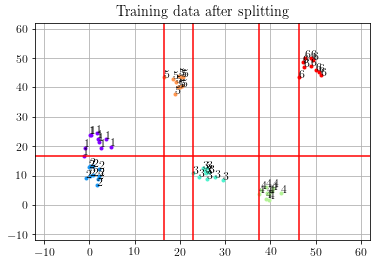

In [328]:
x_split=df_results[df_results["dimension"]==0]["cut value"].values
y_split=df_results[df_results["dimension"]==1]["cut value"].values

display(df_results)
plotData_tree_split(clusters, x_split, y_split, title="Training data after splitting")

Visualize decision tree structure

We are now extracting the data structure. As can see from the resulting dataframe below, split values for the left labels are always split further as follows:


```4 labels on one side -> 3 more rows to divide them into unique labels
3 -> 2
2 -> 1
1 -> 0.
```


If the labels are on the right, then the number of rows to jump is `# labels on the left - 1`.

In [329]:
df_results

,cut value,entropy,left clusters,right clusters,left labels,right labels,dimension
29,22.8047,1.58496,3,3,"[1.0, 2.0, 5.0]","[3.0, 4.0, 6.0]",0
19,16.5613,0.666667,2,1,"[1.0, 2.0]",[5.0],0
9,16.6664,-0,1,1,[2.0],[1.0],1
9,37.4108,0.666667,1,2,[3.0],"[4.0, 6.0]",0
9,46.3278,-0,1,1,[4.0],[6.0],0


We will now set up a data structure to save the decision strucutre, left and right labels and pointers to the next decision rule.

In [330]:
# Binary tree node to save binary tree nodes
class Node:
    """
    constructor for new nodes
    # decision rule is the rule which splits labels in two groups labels_left and labels_right
    # left_rule and right_rule are pointers to the rules that have to be used 
    # to further split labels_left and labels_right
    """
    
    def __init__(self):
        self.decisionrule = None
        self.split_value = None
        self.dimension = None
        self.left_rule = None
        self.right_rule = None
        self.labels_left = None
        self.labels_right = None
    def __format__(self):
        print("rule: " + self.decisionrule)
        print("dimension: " + str(self.dimension))
        print("split value: " + str(self.split_value))
        print("left labels after split: " + str(self.labels_left))
        print("right labels after split: " + str(self.labels_right))
        if self.left_rule is not None:
            print("next decision rule left: " + self.left_rule)
        if self.right_rule is not None:
            print("next decision rule right: " + self.right_rule)
            

In [331]:
# test data structure
x = Node()
x.decisionrule

We will now extract the decision tree according to the explanations below.

In [332]:
def traverse_tree(df,decision_tree):
    node = Node()
    labels = np.asarray(df[["left labels","right labels"]].values)
    labels_left=labels[0,0]
    labels_right=labels[0,1]
    def decision_string(ind):
        """print a decision rule on one line as a string (e.g., `d(2) < 20`)"""
        thisrow = df.iloc[ind]
        other_dim=thisrow.loc["dimension"]
        other_val=thisrow.loc["cut value"]
        string = "d(" + str(other_dim) + ") < " + str(other_val)
        return string

    node.decisionrule=decision_string(0)
    node.dimension=df.iloc[0].loc["dimension"]
    node.split_value=df.iloc[0].loc["cut value"]
    node.labels_left=labels_left
    node.labels_right=labels_right

    for i, row in enumerate(labels[1:,:]):

        thisrow_labels_left = labels[0,0] # labels of this row, e.g., [2, 3, 6]
        thisrow_labels_right = labels[0,1] # labels of this row, e.g., [2, 3, 6]

        otherrow = np.concatenate(row) # labels of other row, e.g., [2, 3, 6]
        if len(np.setdiff1d(thisrow_labels_left,otherrow))==0: # one of the rows below contains all values of the current topmost row
            node.left_rule=decision_string(i+1)
        elif len(np.setdiff1d(thisrow_labels_right,otherrow))==0:
            node.right_rule=decision_string(i+1)

    decision_tree.append(node)
    if len(labels)>1:
        traverse_tree(df.iloc[1:,:],decision_tree)

def create_decision_tree(df):
    decision_tree=[]
    traverse_tree(df,decision_tree)
    return decision_tree

decision_tree=create_decision_tree(df_results)

#for i in decision_tree:
#    i.__format__()

In [333]:
df_results

,cut value,entropy,left clusters,right clusters,left labels,right labels,dimension
29,22.8047,1.58496,3,3,"[1.0, 2.0, 5.0]","[3.0, 4.0, 6.0]",0
19,16.5613,0.666667,2,1,"[1.0, 2.0]",[5.0],0
9,16.6664,-0,1,1,[2.0],[1.0],1
9,37.4108,0.666667,1,2,[3.0],"[4.0, 6.0]",0
9,46.3278,-0,1,1,[4.0],[6.0],0


We can see that using the splits above, all clusters can be partitioned into subregions.

### Test data
Next, we want to estimate the label of a new data point from the decision tree just built. We will always follow the path of strongest reduction of entropy.

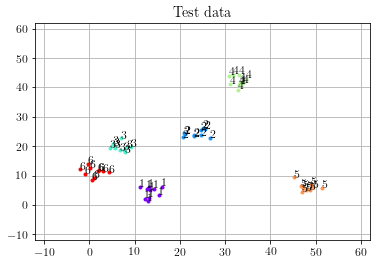

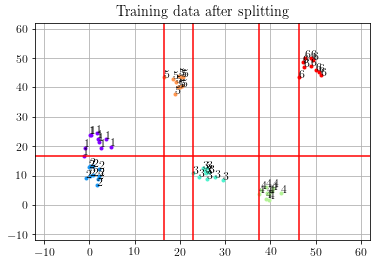

In [334]:
# first, we create a new test dataset
dataset_test, clusters_test = createData(nclusters, dimensions, covariance, npoints)
plotData(clusters_test, title = "Test data")
plotData_tree_split(clusters,x_split,y_split, "Training data after splitting")

The function belows enables descending the tree.

In [335]:
def descend_decision_tree(data_test, node, decision_tree):
    """given some test data and decision tree, assign the correct label using a decision tree"""
    #node.__format__()
    # check left or right side
    if data_test[node.dimension]<node.split_value: # split to the left
        if len(node.labels_left)==1: # if there is only one label, return it
            return int(node.labels_left)
        else:
            if node.left_rule is not None: # else descent
                for i in decision_tree:
                    if i.decisionrule==node.left_rule:
                        return descend_decision_tree(data_test, i, decision_tree)
    else: # split to the right
        if len(node.labels_right)==1:
            return int(node.labels_right)
        else:
            if node.right_rule is not None:
                for i in decision_tree:
                    if i.decisionrule==node.right_rule:
                        return descend_decision_tree(data_test, i, decision_tree)

## if only one label on one of the leaves, return the label
## else, descend the tree   
    
dataset_test_eval=[]
for i in dataset_test[:,:2]:
    label=descend_decision_tree(i,decision_tree[0], decision_tree)
    dataset_test_eval.append(np.concatenate([i,[label]]))
dataset_test_eval=np.asarray(dataset_test_eval)

In [336]:
def data_to_clusters(dataset):
    clusters=[]
    for val in np.unique(dataset[:,2]):
        clusters.append(dataset[dataset[:,2]==val])
    return clusters

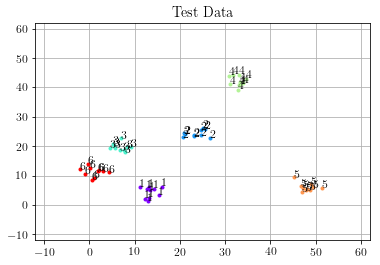

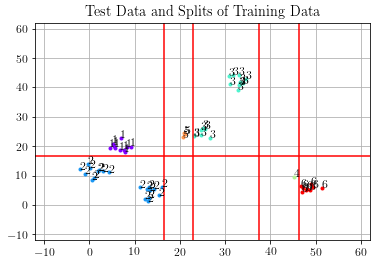

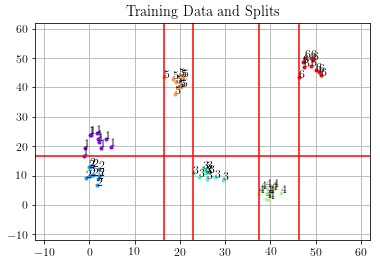

In [337]:
clusters_eval=data_to_clusters(dataset_test_eval)
plotData(clusters_test, "Test Data")
plotData_tree_split(clusters_eval, x_split, y_split, "Test Data and Splits of Training Data")
plotData_tree_split(clusters,x_split,y_split, "Training Data and Splits")

The data is partitioned using the decision tree of the other dataset, therefore some clusters are split randomly in several parts.